In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from glob import glob
%matplotlib inline

In [120]:
any_stack_heights = np.loadtxt('any-stack-v2-steps-37k/transitions/stack-height.log.txt')
any_stack_actions = np.loadtxt('any-stack-v2-steps-37k/transitions/executed-action.log.txt')
any_stack_trials = np.loadtxt('any-stack-v2-steps-37k/transitions/trial.log.txt')
transfer_heights = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/stack-height.log.txt')
transfer_actions = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/executed-action.log.txt')
transfer_trials = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/trial.log.txt')
grasp_actions = np.loadtxt('train-grasp-place-split-efficientnet-21k-acc/transitions/executed-action.log.txt')
grasp_trials = np.loadtxt('train-grasp-place-split-efficientnet-21k-acc/transitions/trial.log.txt')
# row_lengths = np.loadtxt('check_row/transitions/stack-height.log.txt')
# row_actions = np.loadtxt('check_row/transitions/executed-action.log.txt')
window=1000

In [55]:
trials = any_stack_trials
heights = any_stack_heights
print((trials[1:] > trials[:-1]).sum())
print((heights == 4).sum())
print(np.logical_and(trials[1:] > trials[:-1], heights == 4).sum())

4619
2260
2260


[1. 0. 1. ... 1. 1. 1.]


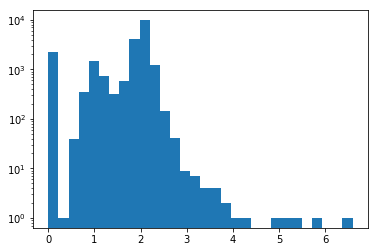

In [35]:
print(grasp_actions[:, 0])
plt.hist(grasp_label_value, bins=30)
plt.yscale('log')

In [127]:
def get_grasp_success_rate(actions, window=200):
    """Evaluate moving window of grasp success rate
    actions: Nx4 array of actions giving [id, rotation, i, j]
    
    """
    grasps = actions[:, 0] == 1
    places = actions[:, 0] == 2
    success_rate = np.zeros(actions.shape[0] - 1)
    success_var = np.zeros_like(success_rate)
    for i in range(success_rate.shape[0]):
        start = max(i - window, 0)
        success_rate[i] = places[start+1: i+2][grasps[start:i+1]].mean()
        success_var[i] = success_rate[start:i+1].std()
    return success_rate, success_var

def get_place_success_rate(stack_height, actions, include_push=False, window=200):
    """
    stack_heights: length N array of integer stack heights
    actions: Nx4 array of actions giving [id, rotation, i, j]
    
    where id=0 is a push, id=1 is grasp, and id=2 is place.
    
    """
    if include_push:
        success_possible = actions[:, 0] == 2
    else:
        success_possible = np.logical_or(actions[:, 0] == 0, actions[:, 0] == 2)
    
    stack_height_increased = np.zeros_like(stack_height, np.bool)
    stack_height_increased[0] = False
    stack_height_increased[1:] = stack_height[1:] > stack_height[:-1]
    
    success_rate = np.zeros_like(stack_height)
    success_var = np.zeros_like(success_rate)
    for i in range(stack_height.shape[0]):
        start = max(i - window, 0)
        success_rate[i] = stack_height_increased[start:i+1][success_possible[start:i+1]].mean()
        success_rate[np.isnan(success_rate)] = 0
        success_var[i] = success_rate[start:i+1].std()
    return success_rate, success_var

def get_action_efficiency(stack_height, window=200, ideal_actions_per_trial=6, max_height=4):
    """Calculate the running action efficiency from successful trials.

    trials: array giving the number of trials up to iteration i (TODO: unused?)
    min_actions: ideal number of actions per trial
    
    Formula: successful_trial_count * ideal_actions_per_trial / window_size
    """

    success = stack_height == max_height
    efficiency = np.zeros_like(stack_height, np.float64)
    efficiency_var = np.zeros_like(efficiency)
    for i in range(1, efficiency.shape[0]):
        start = max(i - window, 1)
        window_size = min(i, window)
        num_trials = success[start:i+1].sum()
        efficiency[i] = num_trials * ideal_actions_per_trial / window_size
        efficiency_var[i] = efficiency[start:i+1].std()
    return efficiency, efficiency_var

def get_grasp_action_efficiency(actions, trials, window=200, ideal_actions_per_trial=3):
    """Get grasp efficiency from when the trial count increases.
    
    """
    
    efficiency = np.zeros_like(trials, np.float64)
    efficiency_var = np.zeros_like(efficiency)
    for i in range(1, efficiency.shape[0]):
        start = max(i - window, 1)
        window_size = min(i, window)
        num_trials = (trials[start:i+1] > trials[start-1:i]).sum()
        efficiency[i] = num_trials * ideal_actions_per_trial / window_size
        efficiency_var[i] = efficiency[start:i+1].std()
    return efficiency, efficiency_var

In [132]:
window = 1000
heights = any_stack_heights
actions = any_stack_actions
trials = any_stack_trials
grasp_rate, grasp_var = get_grasp_success_rate(actions, window=window)
place_rate, place_var = get_place_success_rate(heights, actions, window=window)
eff, eff_var = get_action_efficiency(heights, window=window)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.


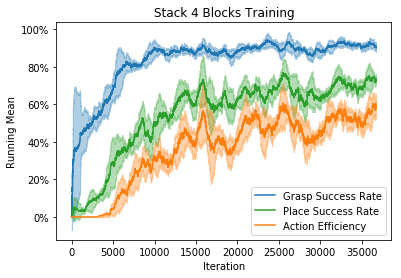

In [133]:
colors = ['tab:blue', 'tab:green', 'tab:orange']
stds = 3
alpha = 0.35
mult = 100

plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
plt.plot(mult*place_rate, color=colors[1], label='Place Success Rate')
plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                 mult*(grasp_rate - stds*grasp_var), 
                 mult*(grasp_rate + stds*grasp_var), 
                 color=colors[0], alpha=alpha)
plt.fill_between(np.arange(1, place_rate.shape[0]+1), 
                 mult*(place_rate - stds*place_var),
                 mult*(place_rate + stds*place_var),
                 color=colors[1], alpha=alpha)
plt.fill_between(np.arange(1, eff.shape[0]+1), 
                 mult*(eff - stds*eff_var),
                 mult*(eff + stds*eff_var), 
                 color=colors[2], alpha=alpha)

ax = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Stack 4 Blocks Training')
plt.legend()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig('grasp_place_stack_efficiency.pdf')

In [128]:
window = 1000
actions = grasp_actions
trials = grasp_trials
grasp_rate, grasp_var = get_grasp_success_rate(actions, window=window)
eff, eff_var = get_grasp_action_efficiency(actions, trials, window=window)

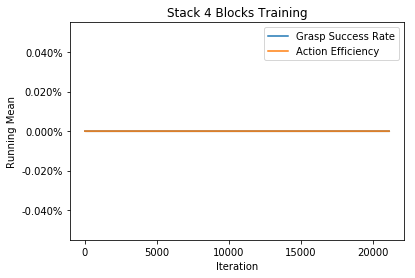

In [131]:
colors = ['tab:blue', 'tab:green', 'tab:orange']
stds = 3
alpha = 0.35
mult = 100

plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                 mult*(grasp_rate - stds*grasp_var), 
                 mult*(grasp_rate + stds*grasp_var), 
                 color=colors[0], alpha=alpha)
plt.fill_between(np.arange(1, eff.shape[0]+1), 
                 mult*(eff - stds*eff_var),
                 mult*(eff + stds*eff_var), 
                 color=colors[2], alpha=alpha)

ax = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Stack 4 Blocks Training')
plt.legend()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig('grasp_efficiency.pdf')